In [663]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import re
import timeit
import nltk
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import csv
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
from bs4 import BeautifulSoup

In [531]:
df = pd.read_csv("train.csv")

In [532]:
df

id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
404285  404285  433578  379845   
404286  404286   18840  155606   
404287  404287  537928  537929   
404288  404288  537930  537931   
404289  404289  537932  537933   

                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
404285  How many keywords are there in the Racket prog...   
404286          Do you believe there is life after death?   
404287                                  What is one coin?   
404288  What is the approx annual cost of living while...   
404289              What is like to have sex with cousin?   

                                                question2  is_duplicate  
0       What is the step by step guide to invest in sh...             0  
1       What would happen if the Indian government sto...             0  
2       How can Internet speed be increased by hacking...             0  
3       Find the remainder when [math]23^{24}[/math] i...             0  
4                 Which fish would survive in salt water?             0  
...                                                   ...           ...  
404285  How many keywords are there in PERL Programmin...             0  
404286         Is it true that there is life after death?             1  
404287                                  What's this coin?             0  
404288  I am having little hairfall problem but I want...             0  
404289      What is it like to have sex with your cousin?             0  

[404290 rows x 6 columns]

## Insight

#### Number of duplicate(smilar) and non-duplicate(non similar) questions

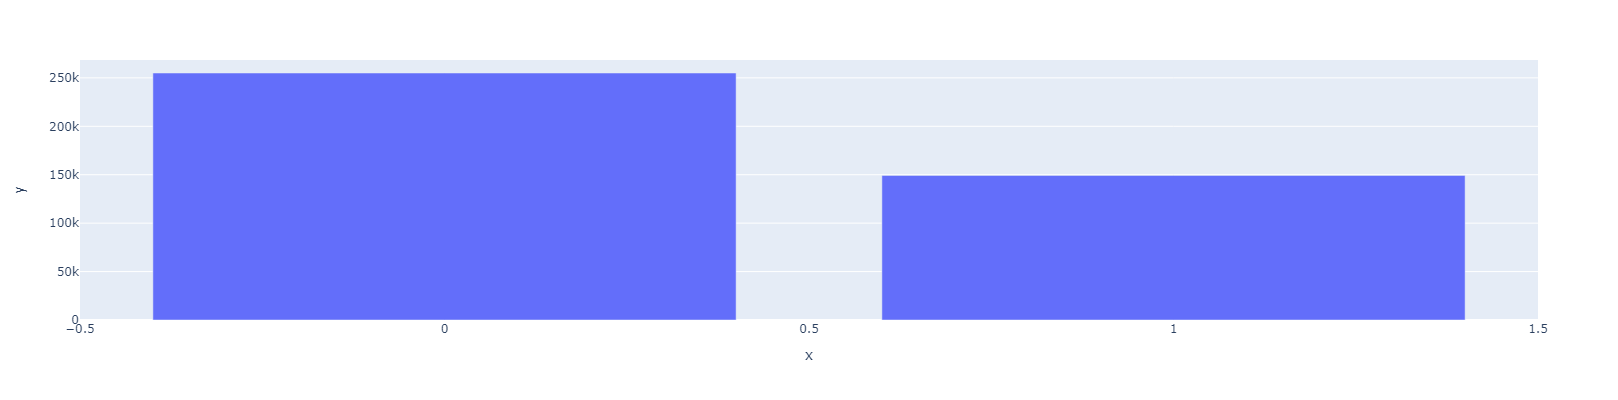

In [533]:
data_X = df.groupby('is_duplicate')['id'].count()
fig = px.bar(x=data_X.index, y=data_X,width=800, height=400, )
fig.show()

In [534]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


#### Questions pairs similar or not similar

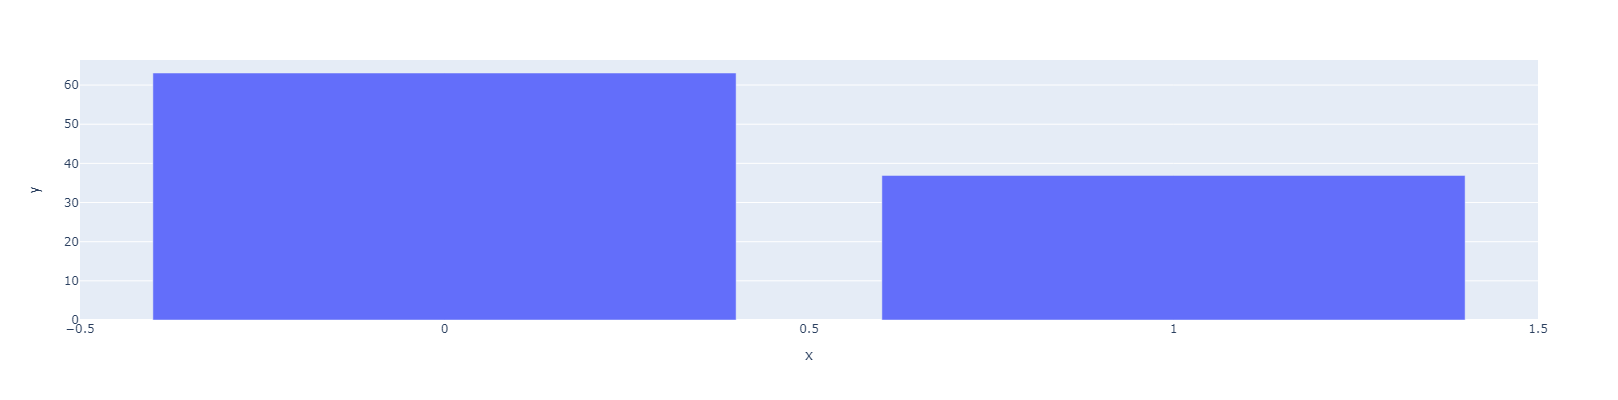

In [535]:
sim_or_notsim = df['is_duplicate'].value_counts()/len(df)*100
fig = px.bar(x=sim_or_notsim.index, y=sim_or_notsim,width=800, height=400, )
fig.show()

#### Number of unique questions

In [536]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qid))
qs_morethan_onetime = np.sum(qid.value_counts() > 1)

In [537]:
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

Total number of  Unique Questions are: 537933



In [538]:
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)



In [539]:
print ('Max number of times a single question is repeated: {}\n'.format(max(qid.value_counts()))) 

Max number of times a single question is repeated: 157



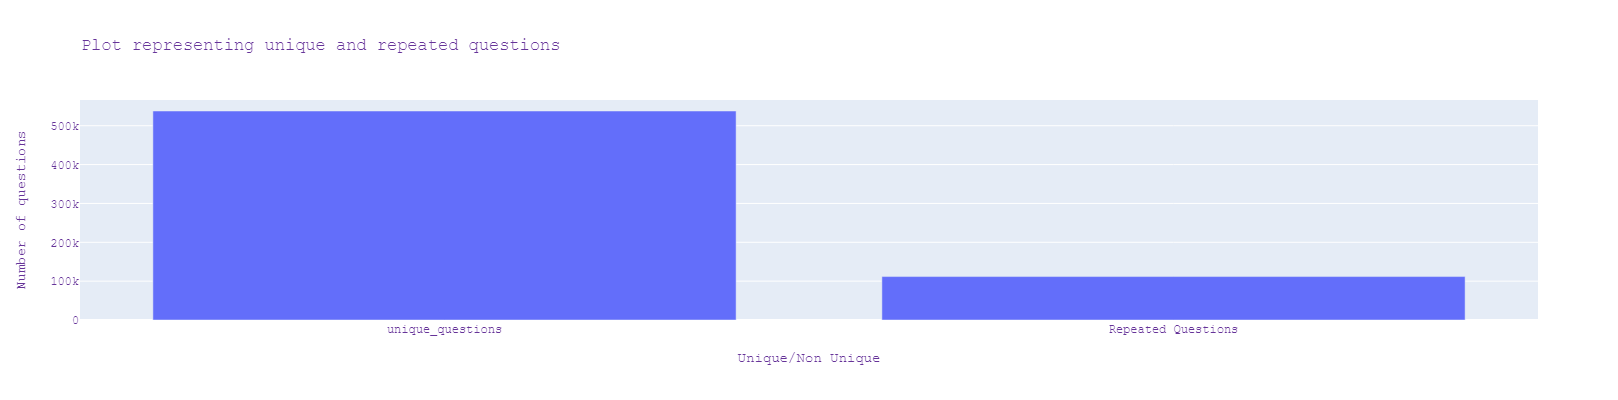

In [540]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]
fig = px.bar(x=x, y=y,width=800, height=400,title="Plot representing unique and repeated questions  " )
fig.update_layout(
    xaxis_title='Unique/Non Unique',
    yaxis_title='Number of questions',
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

### Checking duplicate

In [541]:
pair_df = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

In [542]:
pair_df.shape[0]-df.shape[0]

0

### Number of ocurrance of each question

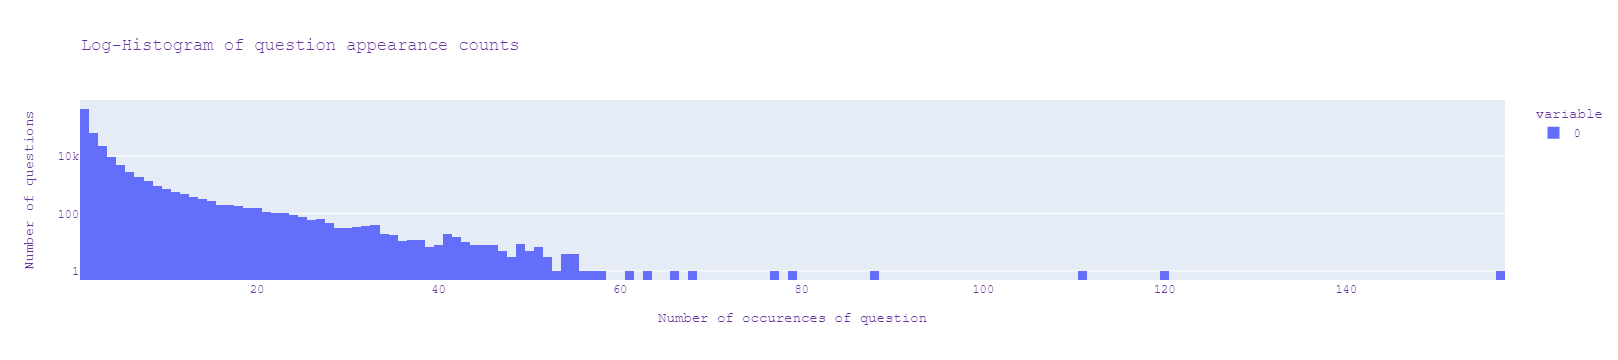

In [543]:
fig  = px.histogram(qid.value_counts(),nbins=160,log_y=True,title='Log-Histogram of question appearance counts')
fig.update_layout(
    xaxis_title='Number of occurences of question',
    yaxis_title='Number of questions',
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

### Checking Null Values

In [544]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [545]:
df[df.isnull().any(1)]
# df[(df['question1'].isnull()) | (df['question2'].isnull())]

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

In [547]:
df = df.fillna('')

In [550]:
# df[(df['question1'].isnull()) | (df['question2'].isnull())]
df[df.isnull().any(1)]

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

## Feature extraction

In [551]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['len_q1'] = df['question1'].str.len()
df['len_q2'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df['q1_uniq_words'] = df['question1'].apply(lambda row: len(set(row.split())))
df['q2_uniq_words'] = df['question2'].apply(lambda row: len(set(row.split())))
df['total_freq'] = df['freq_qid1'] + df['freq_qid2']
df['abs_freq'] = abs(df['freq_qid1'] - df['freq_qid2'])

In [552]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1&w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)


## EDA 

In [553]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'len_q1', 'len_q2', 'q1_n_words',
       'q2_n_words', 'q1_uniq_words', 'q2_uniq_words', 'total_freq',
       'abs_freq', 'word_Common', 'word_Total', 'word_share'],
      dtype='object')

In [554]:
print('Minimum length of question in q1 :', min(df['q1_n_words']))
print('Minimum length of question in q2 :', min(df['q2_n_words']))
print('number of question with minimum length in  q1 :', df[df['q1_n_words']==1].shape[0])
print('number of question with minimum length in  q2 :', df[df['q2_n_words']==1].shape[0])

Minimum length of question in q1 : 1
Minimum length of question in q2 : 1
number of question with minimum length in  q1 : 67
number of question with minimum length in  q2 : 24


In [555]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# fig = make_subplots(rows=1, cols=2, start_cell="bottom-left")

# fig.add_trace(go.violin(x=df['is_duplicate'], y=df["word_share"]),
#               row=1, col=1)
# fig.add_trace(go.histogram(x=df['is_duplicate'], y=df["word_share"],marginal="box" ),
#               row=1, col=2)
# fig.show()

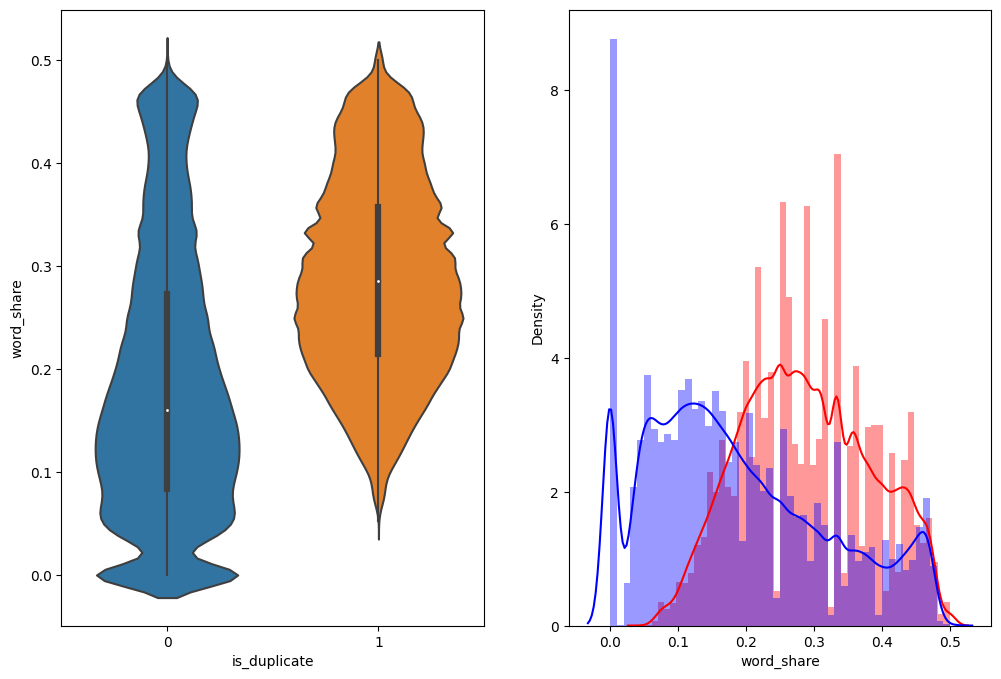

In [556]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

### word_Common 

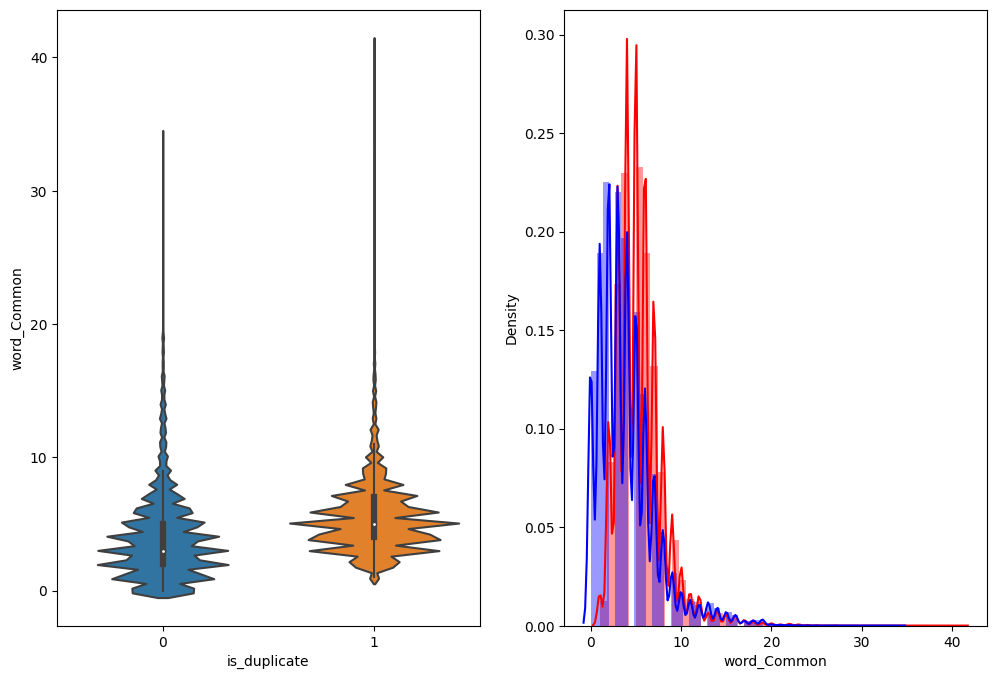

In [557]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## Data Preprocessing

### Remove Tags

In [559]:
def remove_tag(raw_text):
    val = re.sub(re.compile('<.*?>'),'',raw_text)
    return val

In [560]:
for i in df['question1']:
    match = re.search('<.*?>',i)
    if match != None:
        print(match)
    else:
        pass
        

<re.Match object; span=(90, 98), match='<1 3) x>'>
<re.Match object; span=(13, 19), match='<*/\\*>'>
<re.Match object; span=(2, 31), match='<img src=x onerror=prompt(1)>'>
<re.Match object; span=(63, 72), match='<Integer>'>
<re.Match object; span=(24, 30), match='<head>'>
<re.Match object; span=(20, 25), match='<div>'>
<re.Match object; span=(18, 23), match='</v\\>'>
<re.Match object; span=(30, 35), match='<img>'>
<re.Match object; span=(16, 25), match='<stdio.h>'>
<re.Match object; span=(64, 72), match='<a href>'>
<re.Match object; span=(18, 23), match='</v\\>'>
<re.Match object; span=(16, 25), match='<stdio.h>'>
<re.Match object; span=(69, 71), match='<>'>
<re.Match object; span=(69, 71), match='<>'>
<re.Match object; span=(16, 25), match='<conio.h>'>
<re.Match object; span=(57, 95), match='<img src ="another_website_image.jpg">'>
<re.Match object; span=(8, 18), match='<iostream>'>
<re.Match object; span=(19, 31), match='< int, int >'>
<re.Match object; span=(16, 25), match='<conio.h

In [561]:
df[df['question1'].str.find('<1 3) x>')!= -1]

id   qid1    qid2  \
21502    21502  40477   40478   
380925  380925  40477  512595   

                                                question1  \
21502   Question- 30^30 - 29^30 whole divided by 30^29...   
380925  Question- 30^30 - 29^30 whole divided by 30^29...   

                                                question2  is_duplicate  \
21502   Homework Question: I have this formula [10 = x...             0   
380925  What is the remainder when [math]x ^ {2016} + ...             0   

        freq_qid1  freq_qid2  len_q1  len_q2  q1_n_words  q2_n_words  \
21502           2          1     124      92          25          20   
380925          2          1     124     132          25          32   

        q1_uniq_words  q2_uniq_words  total_freq  abs_freq  word_Common  \
21502              25             19           3         1          2.0   
380925             25             18           3         1          4.0   

        word_Total  word_share  
21502         44.0    0.045455  
380925        43.0    0.093023

In [562]:
df['question1'] = df['question1'].apply(remove_tag)

In [563]:
for i in df['question1']:
    match = re.search('<.*?>',i)
    if match != None:
        print(match)
    else:
        pass

### LowerCase

In [565]:
val = [x.isupper() for x in df['question1'][0] ]
counter = 0
for i in val:
    if i == False:
        counter = counter + 1
a = len(df['question1'][0]) - counter
print('total number of upper text is ', a)

total number of upper text is  1


In [566]:
df['question1'] = df['question1'].apply(lambda x:x.lower())
df['question2'] = df['question2'].apply(lambda x:x.lower())

In [567]:
val = [x.isupper() for x in df['question1'][0] ]
counter = 0
for i in val:
    if i == False:
        counter = counter + 1
a = len(df['question1'][0]) - counter
print('total number of upper text is ', a)

total number of upper text is  0


### StopWords

In [568]:
enquiry = stopwords.words('english')
for i in df['question1'][0].split():
    for j in enquiry:
        if i == j:
            print('Found ------ ',i)
print("Not Found -------")

Found ------  what
Found ------  is
Found ------  the
Found ------  by
Found ------  to
Found ------  in
Found ------  in
Not Found -------


In [569]:
df['question1'] = df['question1'].apply(lambda x:[item for item in x.split() if item not in enquiry]).apply(lambda x:' '.join(x))
df['question2'] = df['question2'].apply(lambda x:[item for item in x.split() if item not in enquiry]).apply(lambda x:' '.join(x))

In [570]:
for i in df['question1'][0].split():
    for j in enquiry:
        if i == j:
            print('Found ------ ',i)
print("Not Found -------")

Not Found -------


### Remove URls

In [572]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',text)

In [573]:
a = 'british citizen work us doesn’t visa employer? british citizen work free us family there? please watch www.forme.com'
remove_url(a)

'british citizen work us doesn’t visa employer? british citizen work free us family there? please watch '

In [574]:
df['question1'] = df['question1'].apply(remove_url)
df['question2'] = df['question2'].apply(remove_url)

### Chat word treatment

In [575]:
slang = []
full_form = []
fileName = "slang.txt"
# File Access mode [Read Mode]
accessMode = "r"
with open(fileName, accessMode) as myCSVfile:
    # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
    dataFromFile = csv.reader(myCSVfile, delimiter="=")
    for i in dataFromFile:
        slang.append(i[0]),full_form.append(i[-1])
slang_word = pd.DataFrame({'slang':slang, 'full_form': full_form}) 

In [576]:
chat_words = {'AFAIK': 'As Far As I Know',
 'AFK': 'Away From Keyboard',
 'ASAP': 'As Soon As Possible',
 'ATK': 'At The Keyboard',
 'ATM': 'At The Moment',
 'A3': 'Anytime, Anywhere, Anyplace',
 'BAK': 'Back At Keyboard',
 'BBL': 'Be Back Later',
 'BBS': 'Be Back Soon',
 'BFN': 'Bye For Now',
 'B4N': 'Bye For Now',
 'BRB': 'Be Right Back',
 'BRT': 'Be Right There',
 'BTW': 'By The Way',
 'B4': 'Before',
 'CU': 'See You',
 'CUL8R': 'See You Later',
 'CYA': 'See You',
 'FAQ': 'Frequently Asked Questions',
 'FC': 'Fingers Crossed',
 'FWIW': "For What It's Worth",
 'FYI': 'For Your Information',
 'GAL': 'Get A Life',
 'GG': 'Good Game',
 'GN': 'Good Night',
 'GMTA': 'Great Minds Think Alike',
 'GR8': 'Great!',
 'G9': 'Genius',
 'IC': 'I See',
 'ICQ': 'I Seek you (also a chat program)',
 'ILU': 'ILU: I Love You',
 'IMHO': 'In My Honest/Humble Opinion',
 'IMO': 'In My Opinion',
 'IOW': 'In Other Words',
 'IRL': 'In Real Life',
 'KISS': 'Keep It Simple, Stupid',
 'LDR': 'Long Distance Relationship',
 'LMAO': 'Laugh My A.. Off',
 'LOL': 'Laughing Out Loud',
 'LTNS': 'Long Time No See',
 'L8R': 'Later',
 'MTE': 'My Thoughts Exactly',
 'M8': 'Mate',
 'NRN': 'No Reply Necessary',
 'OIC': 'Oh I See',
 'PITA': 'Pain In The A..',
 'PRT': 'Party',
 'PRW': 'Parents Are Watching',
 'QPSA?\tQue Pasa?': 'QPSA?\tQue Pasa?',
 'ROFL': 'Rolling On The Floor Laughing',
 'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
 'ROTFLMAO': 'Rolling On The Floor Laughing My A.. Off',
 'SK8': 'Skate',
 'STATS': 'Your sex and age',
 'ASL': 'Age, Sex, Location',
 'THX': 'Thank You',
 'TTFN': 'Ta-Ta For Now!',
 'TTYL': 'Talk To You Later',
 'U': 'You',
 'U2': 'You Too',
 'U4E': 'Yours For Ever',
 'WB': 'Welcome Back',
 'WTF': 'What The F...',
 'WTG': 'Way To Go!',
 'WUF': 'Where Are You From?',
 'W8': 'Wait...',
 '7K': 'Sick:-D Laugher'}


In [577]:
  def translator(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words[w.upper()])
        else:
            new_text.append(w)
    return ' '.join(new_text)

In [578]:
translator('LMAO he is the best')

'Laugh My A.. Off he is the best'

In [579]:
print("{0:20}{1:20}".format('word','lemma'))   
for word in df['question2'][:10]:
    print("{0:20}--------------------------------------------------------{1:20}".format(word, translator(word))) 


word                lemma               
step step guide invest share market?--------------------------------------------------------step step guide invest share market?
would happen indian government stole kohinoor (koh-i-noor) diamond back?--------------------------------------------------------would happen indian government stole kohinoor (koh-i-noor) diamond back?
internet speed increased hacking dns?--------------------------------------------------------internet speed increased hacking dns?
find remainder [math]23^{24}[/math] divided 24,23?--------------------------------------------------------find remainder [math]23^{24}[/math] divided 24,23?
fish would survive salt water?--------------------------------------------------------fish would survive salt water?
i'm triple capricorn (sun, moon ascendant capricorn) say me?--------------------------------------------------------i'm triple capricorn (sun, moon ascendant capricorn) say me?
keeps childern active far phone video games?---

In [580]:
# df['question1'] = df['question1'].apply(translator)
# df['question2'] = df['question2'].apply(translator)

### Spelling treatment

In [582]:
incorr = 'british citizen work us doesn’t visa employer? british citizen work free us family there?'
start = timeit.default_timer()
textb = TextBlob(incorr)
print(textb.correct().string)
stop = timeit.default_timer()
print("time-taken :", (stop-start))
print("whole time-taken :",(stop-start)*len(df))

british citizen work us doesn’t isa employer? british citizen work free us family there?
time-taken : 0.0034530000120867044
whole time-taken : 1396.0133748865337


In [583]:
def correction(text):
    textb = TextBlob(text)
    return textb.correct().string 

In [584]:
# df['question1'] = df['question1'].apply(translator)
# df['question2'] = df['question2'].apply(translator)

### Stemming

In [651]:
ps =  PorterStemmer()
punct = '?:!.,;'
sent_word = nltk.word_tokenize(df['question1'][0])
for word in sent_word:
    if word in punct:
        sent_word.remove(word)
print("{0:20}{1:20}".format('word','lemma'))   
for word in sent_word:
    print("{0:20}{1:20}".format(word, ps.stem(word) )) 
print('')
print('*-'*50)
print('')
print("time-taken :", (stop-start))
print("whole time-taken :",(stop-start)*len(df))
print('')
print('*-'*50)

word                lemma               
step                step                
step                step                
guide               guid                
invest              invest              
share               share               
market              market              
india               india               

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

time-taken : 0.0034530000120867044
whole time-taken : 1396.0133748865337

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


In [652]:
def stem_word(text):
    return ' '.join([ps.stem(word) for word in text.split() ])

In [653]:
df['question1'] = df['question1'].apply(stem_word)
df['question2'] = df['question2'].apply(stem_word)

### Lemmatization

In [654]:
# start = timeit.default_timer()
# wntlem =  WordNetLemmatizer()
# punct = '?:!.,;'
# sent_word = nltk.word_tokenize(df['question1'][5])
# for word in sent_word:
#     if word in punct:
#         sent_word.remove(word)
# print("{0:20}{1:20}".format('word','lemma'))   
# for word in sent_word:
#     print("{0:20}{1:20}".format(word, wntlem.lemmatize(word,pos='v'))) 
# stop = timeit.default_timer()  
# print('')
# print('*-'*50)
# print('')
# print("time-taken :", (stop-start))
# print("whole time-taken :",(stop-start)*len(df))
# print('')
# print('*-'*50)

In [655]:
# def lemme_word(text):
#     return ' '.join([wntlem.lemmatize(word,pos='v') for word in text.split() ])

### WordCloud

In [656]:
df_duplicate = df[df['is_duplicate']==1]
df_noduplicate = df[df['is_duplicate']==0]

In [657]:
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_noduplicate["question1"], df_noduplicate["question2"]]).flatten()
print ("Total number of words in duplicate pair questions :",len(p))
print ("Total number of words in non duplicate pair questions :",len(n))

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510054


In [658]:
text1 = " ".join(title for title in p)
text2 = " ".join(title for title in n)
stopwords = set(STOPWORDS)
stopwords.add('best')
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
# stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
# stopwords.remove("best")
#stopwords.remove("!")

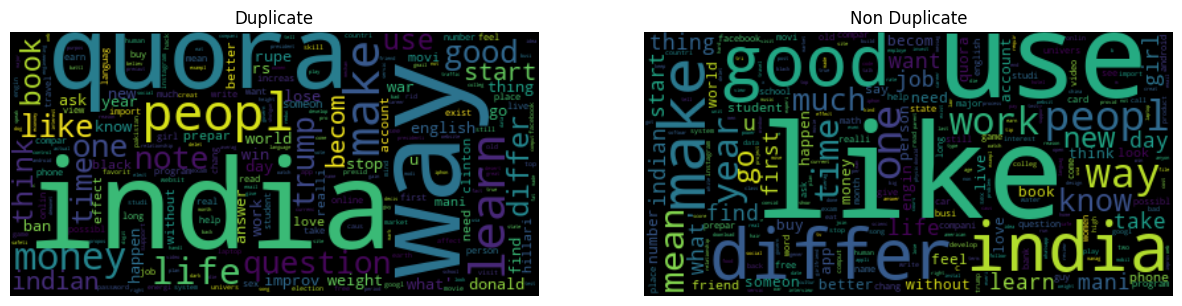

In [659]:
plt.figure(figsize=(15,8))
word_cloud1 = WordCloud(collocations = False,max_words=len(p),stopwords=stopwords, background_color = 'black').generate(text1)
word_cloud2 = WordCloud(collocations = False,max_words=len(n),stopwords=stopwords, background_color = 'black').generate(text2)
plt.subplot(2,2,1)
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.title("Duplicate")
plt.subplot(2,2,2)
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.title("Non Duplicate")
plt.show();

<h2> Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

In [660]:
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

In [664]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [665]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [667]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [676]:
safe_division = 0.0001
STOP_WORDS = stopwords.words("english")

In [685]:
def token(row):
    q1 = row['question1'] 
    q2 = row['question2'] 
    token_features = [0.0]*8
    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    # Get the stopwords in Questions
    q1_stops  = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops  = set([word for word in q2_tokens if word in STOP_WORDS])
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    #cwc_min(min common_word_count)
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + safe_division)
    #cwc_max(max common_word_count)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + safe_division)
    #csc_min(min common_stop_count)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + safe_division)
    #csc_max(max common_stop_count)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + safe_division)
    #ctc_min(min common_token_count)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + safe_division)
    #ctc_max(max common_token_count)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + safe_division)
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    return token_features
    

In [686]:
token_features = df.apply(token, axis=1)

In [688]:
df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [693]:
# import distance
# def fetch_length_features(row):
#     q1 = row['question1']
#     q2 = row['question2']
#     length_features = [0.0]*3
#     # Converting the Sentence into Tokens: 
#     q1_tokens = q1.split()
#     q2_tokens = q2.split()
#     if len(q1_tokens) == 0 or len(q2_tokens) == 0:
#         return length_features
#     # Absolute length features
#     length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
#     #Average Token Length of both Questions
#     length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
#     strs = list(distance.lcsubstrings(q1, q2))
#     length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
#     return length_features

In [694]:
# length_features = df.apply(fetch_length_features, axis=1)

# df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
# df['mean_len'] = list(map(lambda x: x[1], length_features))
# df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [697]:
# Fuzzy Features
from fuzzywuzzy import fuzz
def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']    
    fuzzy_features = [0.0]*4    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)
    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)
    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)
    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)
    return fuzzy_features

In [699]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)



NameError: name 'new_df' is not defined

In [700]:
# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [702]:
print(df.shape)
df.head()

(404290, 31)


id  qid1  qid2                                          question1  \
0   0     1     2           step step guid invest share market india   
1   1     3     4                stori kohinoor  koh i noor  diamond   
2   2     5     6             increas speed internet connect use vpn   
3   3     7     8                             mental lonely  solv it   
4   4     9    10  one dissolv water quikli sugar  salt  methan c...   

                                           question2  is_duplicate  freq_qid1  \
0                 step step guid invest share market             0          1   
1  would happen indian govern stole kohinoor  koh...             0          4   
2                    internet speed increas hack dns             0          1   
3            find remaind 23  24   math  divid 24 23             0          1   
4                       fish would surviv salt water             0          3   

   freq_qid2  len_q1  len_q2  ...  csc_min  csc_max   ctc_min   ctc_max  \
0          1      66      57  ...   0.0000   0.0000  0.833319  0.714276   
1          1      51      88  ...   0.9999   0.9999  0.833319  0.454541   
2          1      73      59  ...   0.0000   0.0000  0.599988  0.499992   
3          1      50      65  ...   0.0000   0.0000  0.000000  0.000000   
4          1      76      39  ...   0.0000   0.0000  0.399992  0.199998   

   last_word_eq  first_word_eq  fuzz_ratio  fuzz_partial_ratio  \
0           0.0            1.0          92                 100   
1           0.0            0.0          65                  94   
2           0.0            0.0          46                  44   
3           0.0            0.0          23                  32   
4           0.0            0.0          23                  46   

   token_sort_ratio  token_set_ratio  
0                92              100  
1                63               90  
2                70               83  
3                25               28  
4                42               53  

[5 rows x 31 columns]

In [669]:
ques_df = df[['question1','question2']]
ques_df.head()

question1  \
0           step step guid invest share market india   
1                stori kohinoor  koh i noor  diamond   
2             increas speed internet connect use vpn   
3                             mental lonely  solv it   
4  one dissolv water quikli sugar  salt  methan c...   

                                           question2  
0                 step step guid invest share market  
1  would happen indian govern stole kohinoor  koh...  
2                    internet speed increas hack dns  
3            find remaind 23  24   math  divid 24 23  
4                       fish would surviv salt water

In [672]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(404290, 14)


is_duplicate  freq_qid1  freq_qid2  len_q1  len_q2  q1_n_words  q2_n_words  \
0             0          1          1      66      57          14          12   
1             0          4          1      51      88           8          13   
2             0          1          1      73      59          14          10   
3             0          1          1      50      65          11           9   
4             0          3          1      76      39          13           7   

   q1_uniq_words  q2_uniq_words  total_freq  abs_freq  word_Common  \
0             12             11           2         0         10.0   
1              8             12           5         3          4.0   
2             14             10           2         0          4.0   
3             10              9           2         0          0.0   
4             13              7           4         2          2.0   

   word_Total  word_share  
0        23.0    0.434783  
1        20.0    0.200000  
2        24.0    0.166667  
3        19.0    0.000000  
4        20.0    0.100000

In [673]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [674]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

MemoryError: Unable to allocate 9.04 GiB for an array with shape (3000, 404290) and data type int64